#**Autoencoder Model for Word Embedding**

#I. Import necessary things

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import re
import os
import pickle
import nltk
import numpy as np
from scipy.spatial import distance

nltk.download('stopwords')
nltk.download('punkt')

2024-10-10 21:34:17.288472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-10 21:34:17.495347: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 21:34:18.474132: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-10-10 21:34:18.474198: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

True

#II. Load corpus and preprocess it

In [2]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/gretelai/synthetic-gsm8k-reflection-405b/" + splits["train"])
df = df[df['topic'].isin(['arithmetic', 'percentages'])]
df = df[['topic', 'question']].rename(columns={'topic': 'label', 'question': 'text'})

corpus = df["text"].to_list()
corpus = "\n".join(corpus)
print(corpus[:1000])


/home/mrzaizai2k/code_Bao/Nlp_co5256/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


During Dia de los Muertos, a store in Mexico City offers a 15% discount on all traditional costumes. If a customer also signs up for the store's newsletter, they receive an additional 5% discount. What is the total percentage discount a customer can receive on a traditional Dia de los Muertos costume?
Kaito is traveling from Tokyo to Seoul and wants to book a flight ticket that originally costs $500. The airline is offering a 15% discount for students, but there's an additional 5% service charge. What is the final amount Kaito needs to pay for the ticket?
Tom is shopping for a new pair of sneakers at a local store in Amsterdam. He has a 20% discount coupon for any purchase over €80 and a 15% discount coupon for any purchase under €80. The store is also offering a 5% discount on all sales over €100. If Tom wants to buy a pair of sneakers originally priced at €120 and a hoodie originally priced at €40, should he buy them together or separately to get the best discount, and what will be t

In [3]:
# Load data
def load_data(csv_file):
    return pd.read_csv(csv_file, encoding="latin")
    
# train_data = load_data("Corona_NLP_train.csv").iloc[:2000]

# corpus = train_data["OriginalTweet"].to_list()
# corpus = "\n".join(corpus)
# print(corpus[:1000])

In [4]:
def text_cleaner(text):
    # lower case text
    text = text.lower()
    text = re.sub(r"'s\b","",text)
    # remove punctuations
    text = re.sub("[^a-zA-Z]", " ", text)
    return text

In [5]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

def preprocess_text(corpus):
  corpus_clean = text_cleaner(corpus)

  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(corpus_clean)
  
  return [w for w in word_tokens if not w in stop_words]

corpus_token =  preprocess_text(corpus)
print(corpus_token)

['dia', 'de', 'los', 'muertos', 'store', 'mexico', 'city', 'offers', 'discount', 'traditional', 'costumes', 'customer', 'also', 'signs', 'store', 'newsletter', 'receive', 'additional', 'discount', 'total', 'percentage', 'discount', 'customer', 'receive', 'traditional', 'dia', 'de', 'los', 'muertos', 'costume', 'kaito', 'traveling', 'tokyo', 'seoul', 'wants', 'book', 'flight', 'ticket', 'originally', 'costs', 'airline', 'offering', 'discount', 'students', 'additional', 'service', 'charge', 'final', 'amount', 'kaito', 'needs', 'pay', 'ticket', 'tom', 'shopping', 'new', 'pair', 'sneakers', 'local', 'store', 'amsterdam', 'discount', 'coupon', 'purchase', 'discount', 'coupon', 'purchase', 'store', 'also', 'offering', 'discount', 'sales', 'tom', 'wants', 'buy', 'pair', 'sneakers', 'originally', 'priced', 'hoodie', 'originally', 'priced', 'buy', 'together', 'separately', 'get', 'best', 'discount', 'total', 'amount', 'pays', 'part', 'school', 'trip', 'sophie', 'taking', 'train', 'paris', 'rome

In [6]:
dictionary = sorted(list(set(corpus_token)))

if os.path.exists("mapping.pkl"):
  print("Load mapping")
  mapping = pickle.load(open("mapping.pkl", "rb"))
else:
  print("Save mapping")
  mapping = dict((c, i) for i, c in enumerate(dictionary))
  pickle.dump(mapping, open("mapping.pkl", "wb"))

print(dictionary)

Load mapping
['ab', 'ababa', 'abdi', 'abeba', 'abeo', 'abidjan', 'ability', 'able', 'absence', 'absorbs', 'abuela', 'abuelita', 'abuelo', 'abuja', 'abundance', 'aburi', 'ac', 'acacia', 'academic', 'academy', 'accelerates', 'accept', 'access', 'accessible', 'accessories', 'accessory', 'accommodate', 'accommodated', 'accommodation', 'accommodations', 'according', 'accordingly', 'account', 'accounted', 'accounting', 'accounts', 'accra', 'accumulated', 'accuracy', 'ace', 'aces', 'achieve', 'achieved', 'achieves', 'achieving', 'acre', 'acres', 'across', 'acrylic', 'act', 'active', 'activities', 'activity', 'actual', 'actually', 'actualmente', 'add', 'added', 'adding', 'addis', 'addition', 'additional', 'additionally', 'additions', 'adds', 'adebayo', 'adebisi', 'adhering', 'adinkra', 'adire', 'adjust', 'adjusted', 'adjusting', 'adjustment', 'administer', 'administered', 'administration', 'administrative', 'administrators', 'admirals', 'admission', 'adopted', 'adoptions', 'adult', 'adults', '

#III. Convert corpus to one-hot vectors & Define embedding dim

In [7]:
embedding_dim = 256
vocab_size = len(dictionary)
print(vocab_size)

5616


In [8]:
print(mapping[corpus_token[10]])

1207


In [9]:
corpus_encode = [mapping[x] for x in corpus_token]
onehot_corpus = keras.utils.to_categorical(corpus_encode, num_classes=vocab_size)
print(onehot_corpus)
print(onehot_corpus.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(158306, 5616)


In [10]:
print(len(onehot_corpus[0]))

5616


#IV. Define Autoencoder model

In [11]:
ae_model = keras.Sequential()
ae_model.add(keras.Input(shape=(vocab_size,)))
ae_model.add(keras.layers.Dense(embedding_dim, activation='relu'))
ae_model.add(keras.layers.Dense(vocab_size, activation='softmax'))

ae_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

# if os.path.exists("ae_model.h5"):
#   ae_model.load_weights("ae_model.h5")

ae_model.summary()

2024-10-10 21:34:30.508321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1437952   
                                                                 
 dense_1 (Dense)             (None, 5616)              1443312   
                                                                 
Total params: 2,881,264
Trainable params: 2,881,264
Non-trainable params: 0
_________________________________________________________________


2024-10-10 21:34:30.599264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-10 21:34:30.599375: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-10 21:34:30.600176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-10 21:34:30.601878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0

#V. Train AE model

In [12]:
len(onehot_corpus)

158306

In [13]:
# Train model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("ae_model.h5", monitor='val_loss', save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

ae_model.fit(x=onehot_corpus, y=onehot_corpus, batch_size=512, epochs=1000,
          validation_split=0.2, validation_freq=1, shuffle=True,
          callbacks=[checkpoint_cb, early_stopping_cb],
          workers=1, use_multiprocessing=False)

ae_model.save("ae_model.h5")

Epoch 1/1000


2024-10-10 21:34:36.748512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-10-10 21:34:36.762403: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55b0de95a930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-10 21:34:36.762435: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-10-10 21:34:36.787953: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-10 21:34:37.150116: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


248/248 [==============================] - 8s 23ms/step - loss: 5.6530 - accuracy: 0.3890 - val_loss: 2.8270 - val_accuracy: 0.7352
Epoch 2/1000
248/248 [==============================] - 3s 14ms/step - loss: 1.7500 - accuracy: 0.8303 - val_loss: 1.3460 - val_accuracy: 0.8758
Epoch 3/1000
248/248 [==============================] - 4s 15ms/step - loss: 0.9887 - accuracy: 0.9035 - val_loss: 0.9922 - val_accuracy: 0.9085
Epoch 4/1000
248/248 [==============================] - 4s 15ms/step - loss: 0.7057 - accuracy: 0.9314 - val_loss: 0.8179 - val_accuracy: 0.9254
Epoch 5/1000
248/248 [==============================] - 4s 14ms/step - loss: 0.5430 - accuracy: 0.9473 - val_loss: 0.7072 - val_accuracy: 0.9396
Epoch 6/1000
248/248 [==============================] - 4s 16ms/step - loss: 0.4336 - accuracy: 0.9583 - val_loss: 0.6271 - val_accuracy: 0.9483
Epoch 7/1000
248/248 [==============================] - 3s 14ms/step - loss: 0.3533 - accuracy: 0.9669 - val_loss: 0.5651 - val_accuracy: 0.954

#=======================================================================

# **How to use trained model**

#=======================================================================

#VI. Load trained model & Get output of 1st FC layer

In [14]:
reconstructed_model = keras.models.load_model("ae_model.h5")
we_model = keras.models.Model(inputs=reconstructed_model.inputs, outputs=reconstructed_model.get_layer('dense').output)

Define function to encode one-hot list of words

In [15]:
def encode_onehot(mapping, list_words):
  output = []
  
  for word in list_words:
    word_vector = [0 for _ in range(vocab_size)]

    if word in mapping.keys():
      word_index = mapping[word]
      word_vector[word_index] = 1
    
    output.append(word_vector)
  
  return output

#VII. Test model

In [16]:
input_sentence = "Covid is very dangerous"

preprocess_sentence = preprocess_text(input_sentence)
onehot_sentence = encode_onehot(mapping, preprocess_sentence)

embedded_sentence = we_model.predict(onehot_sentence)
print(embedded_sentence)

1/1 [==============================] - 0s 71ms/step
[[0.5052032  0.50676805 0.51215047 0.52292305 0.5207464  0.5161057
  0.524773   0.5148385  0.513372   0.5151569  0.52754474 0.52194023
  0.5519581  0.5322616  0.51684296 0.520389   0.51357615 0.5156584
  0.5273161  0.5235582  0.51162857 0.50744593 0.52540284 0.5316317
  0.51434124 0.51784813 0.52722365 0.51453185 0.51855606 0.51861215
  0.51799357 0.523653   0.5157449  0.5294109  0.5225018  0.5081066
  0.5253677  0.52289927 0.519841   0.52464324 0.5134689  0.5231007
  0.5102908  0.5135842  0.51089716 0.51393765 0.5162948  0.53367084
  0.51725185 0.5192106  0.5196859  0.51832765 0.5065622  0.52497196
  0.5308314  0.5158879  0.52503276 0.52758884 0.51326346 0.5128084
  0.5308222  0.5148191  0.5228696  0.5168276  0.5310334  0.5477444
  0.5494667  0.52244467 0.5109874  0.5183878  0.51688063 0.524578
  0.51304543 0.5300933  0.5162495  0.53109413 0.51598895 0.51882535
  0.5108563  0.5147186  0.5287875  0.5242099  0.5261592  0.5288281
  0.52

In [20]:
word_0 = "math"
word_1 = "physics"
word_2 = "number"

preprocess_words = preprocess_text(' '.join([word_0, word_1, word_2]))
onehot_words = encode_onehot(mapping, preprocess_words)

word_0_eb, word_1_eb, word_2_eb = we_model.predict(onehot_words)

# print("OUTPUT EMBEDDING")
# print(word_0_eb)
# print(word_1_eb)
# print(word_2_eb)

dst_0_1 = distance.euclidean(word_0_eb, word_1_eb)
dst_1_2 = distance.euclidean(word_1_eb, word_2_eb)
dst_2_0 = distance.euclidean(word_2_eb, word_0_eb)

print("OUTPUT DISTANCE")
print("0 vs 1: ", dst_0_1)
print("1 vs 2: ", dst_1_2)
print("2 vs 0: ", dst_2_0)

1/1 [==============================] - 0s 27ms/step
OUTPUT DISTANCE
0 vs 1:  4.537856101989746
1 vs 2:  5.7240447998046875
2 vs 0:  7.226943492889404


1/1 [==============================] - 0s 27ms/step


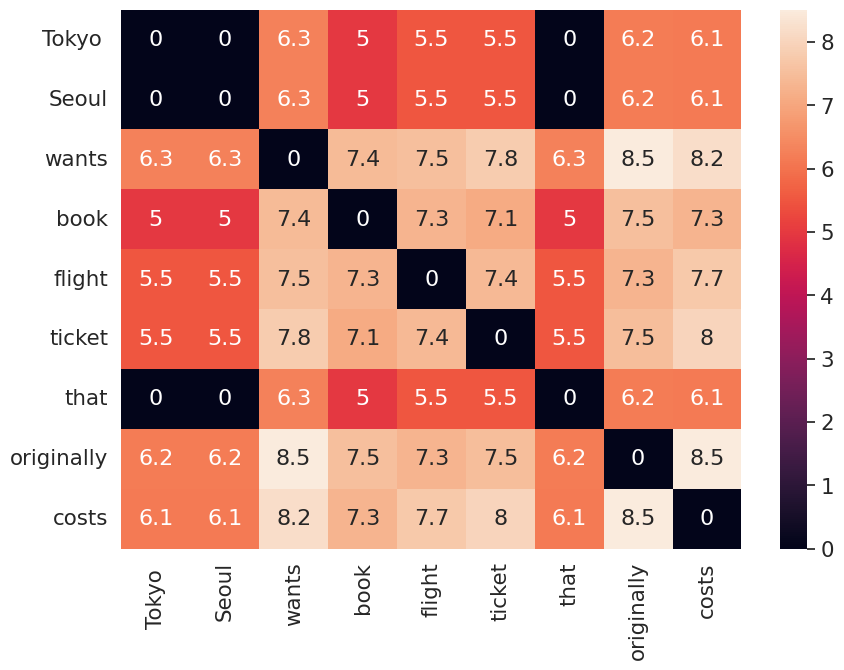

In [24]:
from scipy.spatial import distance_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

list_words = ["Tokyo ", "Seoul", "wants",  "book", "flight", "ticket", "that" ,"originally" ,"costs"]
onehot_words = encode_onehot(mapping, list_words)
list_word_embs = we_model.predict(onehot_words)

dm = distance_matrix(list_word_embs, list_word_embs, p=2)

df_dm = pd.DataFrame(dm, list_words, list_words)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_dm, annot=True, annot_kws={"size": 16}) # font size

plt.show()